# FESOM Mesh System - Nereus

This notebook demonstrates the unified mesh system in nereus for working with FESOM2 ocean model meshes.

## Key Features:
- **Mesh as xr.Dataset**: Meshes are standard xarray Datasets with standardized variable names
- **Standardized variables**: `lon`, `lat`, `area`, `triangles`, `depth`, etc.
- **Standalone spatial functions**: `find_nearest()`, `subset_by_bbox()` work on coordinate arrays
- **Auto dask detection**: Large meshes (>1M points) automatically use dask arrays
- **Model-specific loaders**: `nr.fesom.load_mesh()`, `nr.healpix.load_mesh()`, etc.

## 1. Setup and Imports

In [6]:
import nereus as nr
import numpy as np
import matplotlib.pyplot as plt

print(f"Nereus version: {nr.__version__}")

Nereus version: 0.2.1


## 2. Loading a FESOM Mesh

FESOM meshes can be loaded from:
- A directory containing ASCII files (`nod2d.out`, `elem2d.out`, `aux3d.out`)
- A netCDF file (`fesom.mesh.diag.nc`)

The returned object is an `xr.Dataset` with standardized variable names.

In [7]:
# Load FESOM mesh from directory
# This directory contains: nod2d.out, elem2d.out, aux3d.out, fesom.mesh.diag.nc
mesh = nr.fesom.load_mesh("/Users/nkolduno/PYTHON/DATA/CORE27_mesh")

print(f"Mesh type: {type(mesh)}")
print(f"\nMesh dimensions:")
for dim, size in mesh.sizes.items():
    print(f"  {dim}: {size}")

Mesh type: <class 'xarray.core.dataset.Dataset'>

Mesh dimensions:
  npoints: 126858
  nelem: 244659
  three: 3
  depth_level: 47
  nv: 2


In [8]:
mesh

<xarray.Dataset> Size: 10MB
Dimensions:          (npoints: 126858, nelem: 244659, three: 3,
                      depth_level: 47, nv: 2)
Dimensions without coordinates: npoints, nelem, three, depth_level, nv
Data variables:
    lon              (npoints) float64 1MB 110.9 -102.4 -43.16 ... -78.52 -78.28
    lat              (npoints) float64 1MB -66.15 -74.21 -77.6 ... 24.57 25.03
    triangles        (nelem, three) int32 3MB 1763 96635 125225 ... 19370 94513
    lon_tri          (nelem) float64 2MB -153.8 -45.99 -147.2 ... -78.08 -78.65
    lat_tri          (nelem) float64 2MB -76.9 -72.86 -75.52 ... 25.18 24.27
    area             (npoints) float64 1MB 4.026e+08 1.036e+08 ... 1.565e+09
    depth            (depth_level) float64 376B -2.5 -7.5 ... -6.125e+03
    depth_bounds     (depth_level, nv) float64 752B 0.0 -5.0 ... -6.25e+03
    layer_thickness  (depth_level) float64 376B -5.0 -5.0 ... -350.0 -250.0
Attributes:
    nereus_mesh_type:     fesom
    nereus_mesh_version:  1.0
    nereus_dask_backend:  False
    nereus_source_path:   /Users/nkolduno/PYTHON/DATA/CORE27_mesh

In [9]:
# View all variables in the mesh
print("Mesh variables:")
for var in mesh.data_vars:
    da = mesh[var]
    print(f"  {var}: {da.dims} - {da.attrs.get('long_name', '')}")

Mesh variables:
  lon: ('npoints',) - Longitude
  lat: ('npoints',) - Latitude
  triangles: ('nelem', 'three') - Triangle connectivity (0-indexed)
  lon_tri: ('nelem',) - Element center longitude
  lat_tri: ('nelem',) - Element center latitude
  area: ('npoints',) - Node cluster area
  depth: ('depth_level',) - Depth of layer centers
  depth_bounds: ('depth_level', 'nv') - Layer depth bounds
  layer_thickness: ('depth_level',) - Layer thickness


In [10]:
# Nereus mesh metadata
print("Mesh attributes:")
for key, value in mesh.attrs.items():
    print(f"  {key}: {value}")

Mesh attributes:
  nereus_mesh_type: fesom
  nereus_mesh_version: 1.0
  nereus_dask_backend: False
  nereus_source_path: /Users/nkolduno/PYTHON/DATA/CORE27_mesh


## 3. Accessing Mesh Data

Mesh variables are accessed using standard xarray syntax. Use `.values` to get numpy arrays.

In [11]:
# Access coordinates as xr.DataArray
lon = mesh["lon"]
lat = mesh["lat"]
area = mesh["area"]

print(f"Longitude (xr.DataArray):")
print(f"  Shape: {lon.shape}")
print(f"  Range: [{float(lon.min()):.2f}, {float(lon.max()):.2f}] degrees")
print(f"  Units: {lon.attrs.get('units', 'N/A')}")

print(f"\nLatitude:")
print(f"  Shape: {lat.shape}")
print(f"  Range: [{float(lat.min()):.2f}, {float(lat.max()):.2f}] degrees")

print(f"\nNode area:")
print(f"  Total area: {float(area.sum())/1e12:.2f} × 10¹² m²")
print(f"  (Earth surface: ~510 × 10¹² m²)")

Longitude (xr.DataArray):
  Shape: (126858,)
  Range: [-180.00, 180.00] degrees
  Units: degrees_east

Latitude:
  Shape: (126858,)
  Range: [-78.52, 89.96] degrees

Node area:
  Total area: 364.35 × 10¹² m²
  (Earth surface: ~510 × 10¹² m²)


In [12]:
# Get numpy arrays for use with other functions
lon_np = mesh["lon"].values
lat_np = mesh["lat"].values

print(f"Numpy array type: {type(lon_np)}")
print(f"Numpy array dtype: {lon_np.dtype}")

Numpy array type: <class 'numpy.ndarray'>
Numpy array dtype: float64


## 4. Triangle Connectivity

FESOM uses triangular elements. The `triangles` variable contains the connectivity (0-indexed).

In [13]:
triangles = mesh["triangles"]

print(f"Triangles shape: {triangles.shape}")
print(f"  nelem (number of triangles): {mesh.sizes['nelem']}")
print(f"  three (vertices per triangle): {mesh.sizes['three']}")
print(f"\nFirst 5 triangles (0-indexed node indices):")
print(triangles.values[:5])

print(f"\nIndex range: [{int(triangles.min())}, {int(triangles.max())}]")
print(f"  (0-indexed, max should be < npoints={mesh.sizes['npoints']})")

Triangles shape: (244659, 3)
  nelem (number of triangles): 244659
  three (vertices per triangle): 3

First 5 triangles (0-indexed node indices):
[[  1763  96635 125225]
 [  1477 112277    703]
 [ 78543  78544   5048]
 [  2752 110954  15426]
 [  6463   6457   1834]]

Index range: [0, 126857]
  (0-indexed, max should be < npoints=126858)


In [14]:
# Element (triangle) centers are pre-computed
lon_tri = mesh["lon_tri"].values
lat_tri = mesh["lat_tri"].values

print(f"Element center coordinates:")
print(f"  lon_tri shape: {lon_tri.shape}")
print(f"  lat_tri shape: {lat_tri.shape}")

Element center coordinates:
  lon_tri shape: (244659,)
  lat_tri shape: (244659,)


## 5. Vertical Structure

FESOM meshes include vertical level information.

In [17]:
depth = mesh["depth"]
layer_thickness = mesh["layer_thickness"]
depth_bounds = mesh["depth_bounds"]

print(f"Number of vertical levels: {mesh.sizes['depth_level']}")
print(f"\nDepth of layer centers (first 10):")
print(f"  {depth.values[:10]} m")
print(f"\nLayer thickness (first 10):")
print(f"  {layer_thickness.values[:10]} m")
print(f"\nDepth bounds shape: {depth_bounds.shape}")
print(f"  First layer: {depth_bounds.values[0]} m")
print(f"  Last layer: {depth_bounds.values[-1]} m")

Number of vertical levels: 47

Depth of layer centers (first 10):
  [ -2.5  -7.5 -15.  -25.  -35.  -45.  -55.  -65.  -75.  -85. ] m

Layer thickness (first 10):
  [ -5.  -5. -10. -10. -10. -10. -10. -10. -10. -10.] m

Depth bounds shape: (47, 2)
  First layer: [ 0. -5.] m
  Last layer: [-6000. -6250.] m


## 6. Spatial Queries

Nereus provides standalone spatial query functions that work on coordinate arrays.

In [18]:
# Find nearest mesh point to a location
query_lon, query_lat = 0.0, 0.0  # Equator at prime meridian

idx = nr.find_nearest(lon_np, lat_np, query_lon, query_lat)

print(f"Query point: ({query_lon}, {query_lat})")
print(f"Nearest mesh point index: {idx}")
print(f"Nearest mesh point coordinates: ({lon_np[idx]:.4f}, {lat_np[idx]:.4f})")

Query point: (0.0, 0.0)
Nearest mesh point index: 98866
Nearest mesh point coordinates: (0.1465, 0.0652)


In [19]:
# Get distance as well
idx, dist = nr.find_nearest(lon_np, lat_np, query_lon, query_lat, return_distance=True)

print(f"Distance to nearest point: {dist/1000:.2f} km")

Distance to nearest point: 17.83 km


In [20]:
# Find multiple nearest neighbors
indices = nr.find_nearest(lon_np, lat_np, query_lon, query_lat, k=5)

print(f"5 nearest points to ({query_lon}, {query_lat}):")
for i, idx in enumerate(indices):
    print(f"  {i+1}. Index {idx}: ({lon_np[idx]:.4f}, {lat_np[idx]:.4f})")

5 nearest points to (0.0, 0.0):
  1. Index 98866: (0.1465, 0.0652)
  2. Index 98865: (0.1085, -0.2295)
  3. Index 98867: (-0.1118, 0.2443)
  4. Index 29395: (-0.2558, -0.0944)
  5. Index 72809: (0.1475, 0.3512)


In [21]:
# Query multiple locations at once
query_lons = np.array([-74.0, 2.3, 139.7])  # NYC, Paris, Tokyo
query_lats = np.array([40.7, 48.9, 35.7])

indices = nr.find_nearest(lon_np, lat_np, query_lons, query_lats)

cities = ["New York", "Paris", "Tokyo"]
print("Nearest ocean points to cities:")
for city, qlon, qlat, idx in zip(cities, query_lons, query_lats, indices):
    print(f"  {city} ({qlon}, {qlat}) -> ({lon_np[idx]:.2f}, {lat_np[idx]:.2f})")

Nearest ocean points to cities:
  New York (-74.0, 40.7) -> (-73.95, 40.46)
  Paris (2.3, 48.9) -> (1.23, 49.91)
  Tokyo (139.7, 35.7) -> (139.47, 35.55)


In [22]:
# Subset by bounding box
mask = nr.subset_by_bbox(
    lon_np, lat_np,
    lon_min=-80, lon_max=0,
    lat_min=20, lat_max=70
)

print(f"North Atlantic bounding box: lon=[-80, 0], lat=[20, 70]")
print(f"Points in region: {mask.sum()} / {len(mask)} ({100*mask.sum()/len(mask):.1f}%)")

North Atlantic bounding box: lon=[-80, 0], lat=[20, 70]
Points in region: 16257 / 126858 (12.8%)


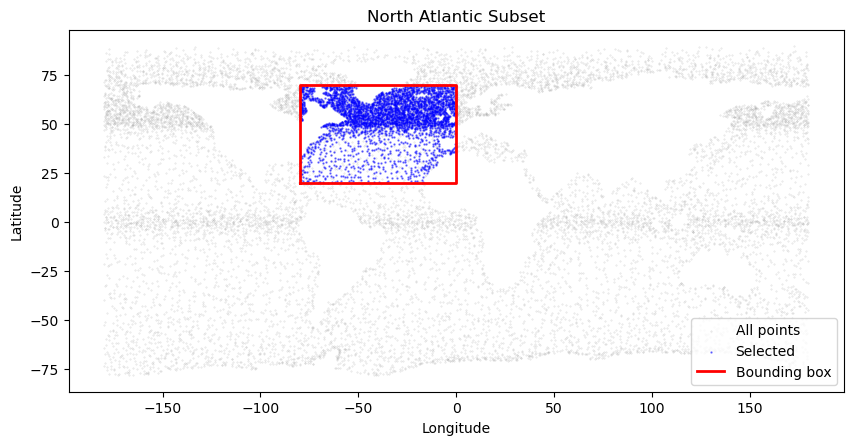

In [23]:
# Visualize the subset
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all points (gray)
ax.scatter(lon_np[::10], lat_np[::10], s=0.1, c='gray', alpha=0.3, label='All points')

# Plot selected points (blue)
ax.scatter(lon_np[mask][::5], lat_np[mask][::5], s=0.5, c='blue', alpha=0.5, label='Selected')

# Draw bounding box
ax.plot([-80, 0, 0, -80, -80], [20, 20, 70, 70, 20], 'r-', linewidth=2, label='Bounding box')

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("North Atlantic Subset")
ax.legend()
ax.set_aspect('equal')

## 7. Using Mesh with Diagnostics

The mesh `area` variable can be used directly with nereus diagnostic functions.

In [24]:
# Create synthetic sea ice concentration data
# High values near poles, zero near equator
sic = np.zeros(mesh.sizes["npoints"])

# Arctic ice (lat > 60)
arctic_mask = lat_np > 60
sic[arctic_mask] = 0.9 * np.exp(-0.05 * (90 - lat_np[arctic_mask]))

# Antarctic ice (lat < -60)
antarctic_mask = lat_np < -60
sic[antarctic_mask] = 0.8 * np.exp(-0.05 * (-lat_np[antarctic_mask] - 60))

print(f"Synthetic SIC: min={sic.min():.2f}, max={sic.max():.2f}")

Synthetic SIC: min=0.00, max=0.90


In [25]:
# Calculate sea ice area using mesh area
# Northern Hemisphere
nh_mask = lat_np > 0
nh_ice_area = nr.ice_area(sic, mesh["area"], mask=nh_mask)

# Southern Hemisphere
sh_mask = lat_np < 0
sh_ice_area = nr.ice_area(sic, mesh["area"], mask=sh_mask)

print(f"Northern Hemisphere ice area: {nh_ice_area/1e12:.2f} × 10⁶ km²")
print(f"Southern Hemisphere ice area: {sh_ice_area/1e12:.2f} × 10⁶ km²")

Northern Hemisphere ice area: 7.21 × 10⁶ km²
Southern Hemisphere ice area: 12.64 × 10⁶ km²


## 8. Plotting with Mesh Coordinates

Use mesh coordinates with `nr.plot()` for visualization.

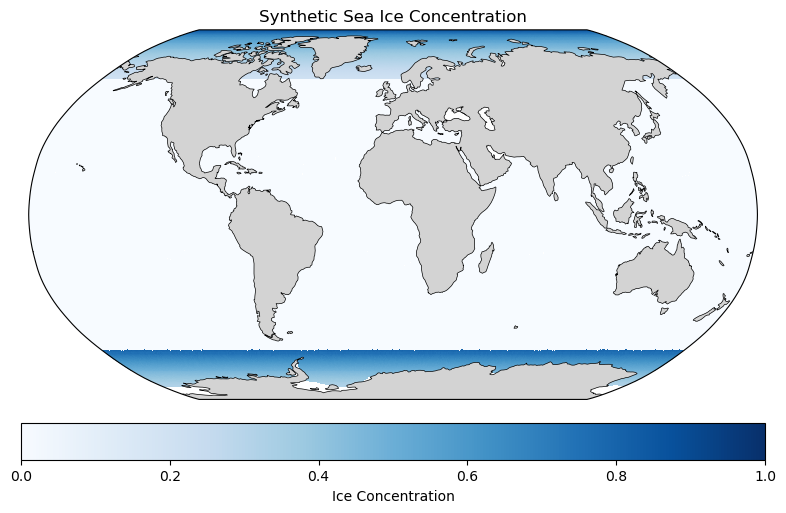

In [26]:
# Plot synthetic sea ice concentration
fig, ax, interp = nr.plot(
    sic,
    mesh["lon"].values,
    mesh["lat"].values,
    projection="rob",
    resolution=0.5,
    cmap="Blues",
    vmin=0, vmax=1,
    title="Synthetic Sea Ice Concentration",
    colorbar_label="Ice Concentration",
    land=True
)

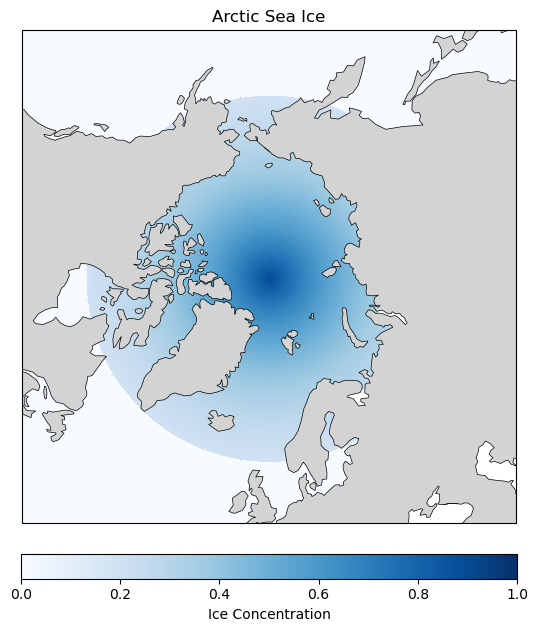

In [27]:
# Arctic view
fig, ax, _ = nr.plot(
    sic,
    mesh["lon"].values,
    mesh["lat"].values,
    projection="np",
    extent=(-180, 180, 50, 90),
    resolution=0.25,
    cmap="Blues",
    vmin=0, vmax=1,
    title="Arctic Sea Ice",
    colorbar_label="Ice Concentration",
    land=True
)

## 9. Universal Mesh Loader

The `nr.load_mesh()` function auto-detects mesh type and loads accordingly.

In [28]:
# Universal loader auto-detects FESOM mesh
mesh2 = nr.load_mesh("/Users/nkolduno/PYTHON/DATA/CORE27_mesh")

print(f"Detected mesh type: {mesh2.attrs['nereus_mesh_type']}")
print(f"Same as direct load: {mesh2.sizes['npoints'] == mesh.sizes['npoints']}")

Detected mesh type: fesom
Same as direct load: True


## 10. Creating Regular Lon-Lat Meshes

Nereus can create regular lon-lat grids as mesh datasets.

In [29]:
# Create a 1-degree regular grid mesh
mesh_1deg = nr.create_lonlat_mesh(1.0)

print(f"1-degree mesh:")
print(f"  npoints: {mesh_1deg.sizes['npoints']}")
print(f"  nlon × nlat: {mesh_1deg.attrs['nlon']} × {mesh_1deg.attrs['nlat']}")
print(f"  Type: {mesh_1deg.attrs['nereus_mesh_type']}")

1-degree mesh:
  npoints: 64800
  nlon × nlat: 360 × 180
  Type: lonlat


In [30]:
# Create regional mesh
mesh_regional = nr.create_lonlat_mesh(
    0.25,  # 0.25 degree resolution
    lon_bounds=(-80, 0),
    lat_bounds=(20, 70)
)

print(f"Regional mesh (North Atlantic):")
print(f"  npoints: {mesh_regional.sizes['npoints']}")
print(f"  nlon × nlat: {mesh_regional.attrs['nlon']} × {mesh_regional.attrs['nlat']}")

Regional mesh (North Atlantic):
  npoints: 64000
  nlon × nlat: 320 × 200


## 11. FESOM-Specific Functions

The `nr.fesom` namespace includes functions specific to FESOM meshes.

In [31]:
# Interpolate node data to element centers
# Example: create temperature-like data on nodes
temp_nodes = 25 - 0.5 * np.abs(lat_np)  # Temperature decreasing with latitude

# Convert to element centers
temp_elements = nr.fesom.node_to_element(temp_nodes, mesh)

print(f"Node data shape: {temp_nodes.shape}")
print(f"Element data shape: {temp_elements.shape}")
print(f"Node mean: {temp_nodes.mean():.2f}°C")
print(f"Element mean: {temp_elements.mean():.2f}°C")

Node data shape: (126858,)
Element data shape: (244659,)
Node mean: 2.47°C
Element mean: 2.57°C


In [32]:
# Interpolate element data back to nodes
temp_back = nr.fesom.element_to_node(temp_elements, mesh)

print(f"Back to nodes shape: {temp_back.shape}")
print(f"Difference: {np.abs(temp_nodes - temp_back).mean():.4f}°C (interpolation error)")

Back to nodes shape: (126858,)
Difference: 0.0067°C (interpolation error)


## Summary

### Key Concepts

**Mesh as xr.Dataset:**
```python
mesh = nr.fesom.load_mesh(path)  # Returns xr.Dataset
lon = mesh["lon"]                # xr.DataArray
lon_np = mesh["lon"].values      # numpy array
```

**Standardized Variable Names:**
| Variable | Description |
|----------|-------------|
| `lon`, `lat` | Coordinates (normalized to [-180, 180]) |
| `area` | Cell/node area in m² |
| `triangles` | 0-indexed triangle connectivity |
| `lon_tri`, `lat_tri` | Element center coordinates |
| `depth` | Layer center depths |
| `layer_thickness` | Layer thickness |
| `depth_bounds` | Layer interfaces |

**Spatial Functions:**
```python
idx = nr.find_nearest(lon, lat, query_lon, query_lat)
mask = nr.subset_by_bbox(lon, lat, lon_min, lon_max, lat_min, lat_max)
```

**With Diagnostics:**
```python
ice_area = nr.ice_area(sic, mesh["area"], mask=mesh["lat"] > 0)
```

### Available Mesh Loaders

| Function | Mesh Type |
|----------|----------|
| `nr.fesom.load_mesh(path)` | FESOM2 unstructured mesh |
| `nr.healpix.load_mesh(npoints)` | HEALPix grid |
| `nr.nemo.load_mesh(path)` | NEMO mesh_mask.nc |
| `nr.load_mesh(path)` | Auto-detect |
| `nr.create_lonlat_mesh(resolution)` | Regular lon-lat grid |

In [33]:
mesh1 = nr.fesom.load_mesh('/Users/nkolduno/PYTHON/DATA/CORE27_mesh/fesom.mesh.diag.nc')

In [34]:
mesh1

<xarray.Dataset> Size: 128MB
Dimensions:            (elem: 244659, npoints: 126858, nz: 48, n3: 3, n2: 2,
                        edg_n: 371644, N: 9, n4: 4, nz1: 47, nelem: 244659,
                        three: 3, depth_level: 47, nv: 2)
Coordinates:
  * nz                 (nz) float64 384B -0.0 5.0 10.0 ... 6e+03 6.25e+03
  * nz1                (nz1) float64 376B 2.5 7.5 15.0 ... 5.825e+03 6.125e+03
Dimensions without coordinates: elem, npoints, n3, n2, edg_n, N, n4, nelem,
                                three, depth_level, nv
Data variables: (12/30)
    fesom_mesh         int32 4B -2147483647
    elem_area          (elem) float64 2MB 2.338e+08 9.12e+08 ... 1.067e+09
    nlevels_nod2D      (npoints) int32 507kB 15 5 22 22 33 5 ... 16 7 31 21 9 14
    nlevels            (elem) int32 979kB 18 21 20 41 36 20 43 ... 9 6 6 14 14 6
    nod_in_elem2D_num  (npoints) int32 507kB 4 2 7 7 6 6 7 7 ... 2 3 7 2 5 6 4 4
    nod_part           (npoints) int32 507kB 148 212 258 243 ... 357 262 360 356
    ...                 ...
    triangles          (nelem, three) int32 3MB 1763 125225 ... 94513 19370
    lon_tri            (nelem) float64 2MB -153.8 -45.99 ... -78.08 -78.65
    lat_tri            (nelem) float64 2MB -76.9 -72.86 -75.52 ... 25.18 24.27
    depth              (depth_level) float64 376B 2.5 7.5 ... 6.125e+03
    depth_bounds       (depth_level, nv) float64 752B -0.0 5.0 ... 6.25e+03
    layer_thickness    (depth_level) float64 376B 5.0 5.0 10.0 ... 350.0 250.0
Attributes:
    Conventions:          UGRID-1.0
    nereus_mesh_type:     fesom
    nereus_mesh_version:  1.0
    nereus_dask_backend:  False
    nereus_source_path:   /Users/nkolduno/PYTHON/DATA/CORE27_mesh/fesom.mesh....